In [424]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### imports

In [438]:
print(__doc__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import entropy as calculate_entropy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Automatically created module for IPython interactive environment


### utilities

In [440]:
def sigmoid(x):
    return 1 / (1 + (np.e**-x))

def build_topic_word_distr(topics, word_topic_cos, words, topic_word_window_width, word_doc_frequency):
    topic_word_distr = pd.DataFrame(data=0.0, columns=topics, index=words)

    for topic in tqdm(range(len(topics))):
        word_topic_co = word_topic_cos[topic]
        word_word_co = pd.DataFrame(data=0.0, columns=word_topic_co[:topic_word_window_width].index, index=words)

        for index, (top_word, corelation) in enumerate(word_topic_co.items()):
#             if index == topic_word_window_width:
#                 break

            word_word_frequency = corelation * word_doc_freqency[word_doc_freqency[top_word] > 0].sum(0)
            trust_factor = sigmoid((word_doc_freqency[top_word] > 0).sum(0))

            word_word_co[top_word] = (word_word_frequency * trust_factor) / word_doc_frequency
        topic_word_distr[topics[topic]] = word_word_co.max(1)
    
    topic_word_distr = topic_word_distr.T
    entropy = np.nan_to_num(calculate_entropy(topic_word_distr, base=2))
    topic_word_distr = (topic_word_distr * (np.e**(-entropy**2))).T
    return topic_word_distr

def infer_topic(label_classes, doc_vector, topic_word_distr):
    doc_topic_word_distr = topic_word_distr.copy()

    for label_class in label_classes:
        doc_topic_word_distr[label_class] *= doc_vector
    
    
    doc_topic = np.max(doc_topic_word_distr).idxmax()
    return doc_topic_word_distr, doc_topic

### load dataset

In [441]:
# total number of samples needed
datasize = 300
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.religion.misc', 'comp.graphics', 'sci.space']
label_classes = ['autos', 'religion', 'graphics', 'space']

assert len(label_classes) == len(categories)

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

### clean dataset

In [442]:
# clean out the new line characters from text in docs
def clean_doc(doc):
    ''' remove unwanter characters line new line '''

    unwanted_chrs = [')', '(', '{', '}', '\t', '\n', '\r', "'", '"', "!"]
    doc = doc.lower()
    for unwanted_chr in unwanted_chrs:
        doc = doc.replace(unwanted_chr, ' ')

    return doc.strip()

In [443]:
labels = []
clean_docs = []
max_document_length = None

# the new classes
sizes = [0] * len(label_classes)
assert len(label_classes) == len(sizes)

for index, doc in enumerate(docs):
    if len(clean_docs) == datasize*len(label_classes):
        break
        
    cd = clean_doc(doc)
    
    if len(cd) == 0 or cd.isspace() or (max_document_length is not None and len(cd) <= max_document_length):
        continue
        
    label_class = classes[old_labels[index]]
    label = categories.index(label_class)

    if sizes[label] < datasize:
        clean_docs.append(cd)
        labels.append(label)

        sizes[label] += 1

labels = np.array(labels)
print(clean_docs[0])

<apparently you re not a woman - my husband hates the auto door locks <feels safer in a car that locks easily  in addition to watching around <in a secluded spot, etc - have my keys ready to open the door so i m


In [444]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes: {label_classes} of size min:{min(sizes)}, max:{max(sizes)}")

there are 1200 docs and 4 classes: ['autos', 'religion', 'graphics', 'space'] of size min:300, max:300


### count words

In [516]:
# initialize the count vectorizer
count_vectorizer = CountVectorizer()
# count_vectorizer = TfidfVectorizer()

# fit it to dataset
train_docs, test_docs, train_labels, test_labels = train_test_split(clean_docs, labels, test_size=.33, random_state=42)
count_vectorizer.fit(train_docs)
vocabulary = count_vectorizer.get_feature_names()

print("word_count is", len(vocabulary))

word_count is 17523


### Prepare Datatset

In [517]:
# create doc count vectors
train_doc_vectors = count_vectorizer.transform(train_docs).toarray()
train_doc_vectors = (train_doc_vectors > 0).astype(float)
train_doc_vectors = normalize(train_doc_vectors, norm="l1", axis=1)

test_doc_vectors = count_vectorizer.transform(test_docs).toarray()
test_doc_vectors = (test_doc_vectors > 0).astype(float)
test_doc_vectors = normalize(test_doc_vectors, norm="l1", axis=1)

print(f"{len(train_labels)} train_docs, {len(test_labels)} test docs")

804 train_docs, 396 test docs


In [518]:
document_word_frequency = pd.DataFrame(train_doc_vectors, columns=count_vectorizer.get_feature_names())
document_word_frequency["__labels__"] = train_labels

print("document_word_frequency shape is", document_word_frequency.shape)

document_word_frequency shape is (804, 17524)


In [519]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes")

there are 1200 docs and 4 classes


In [520]:
document_word_frequency.head()

,00,000,0000,00000,0001,000100255pixel,00041032,0004136,0004246,0004422,...,zullen,zulu,zurbrin,zurvanism,zwaartepunten,zwak,zwakke,zware,zwarte,__labels__
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.000388,0.000388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Prepare Binary Dataset

In [521]:
#reduce freq in doc to bin value of 1 or 0
word_doc_freqency = document_word_frequency.drop(["__labels__"], axis='columns')

#the sum vertically of bin freq
word_doc_total_frequency = word_doc_freqency.sum(0)

### Topic and word corelation

In [522]:
topic_word_distr = pd.DataFrame(data=0.0, columns=label_classes, index=vocabulary)

for topic, label in enumerate(label_classes):
    word_topic_frequency = word_doc_freqency[document_word_frequency['__labels__'] == topic].sum(0)
    trust_factor = sigmoid((word_doc_freqency > 0).sum(0))
    
    topic_word_distr[label] = ((word_topic_frequency * trust_factor) / word_doc_total_frequency).fillna(0)

topic_word_distr = topic_word_distr.T
entropy = np.nan_to_num(calculate_entropy(topic_word_distr, base=2))
topic_word_distr = (topic_word_distr * (np.e**(-entropy**2))).T
print(f"topic_word_distr has shape {topic_word_distr.shape}")

topic_word_distr has shape (17523, 4)


In [523]:
topic_word_distr.head()

,autos,religion,graphics,space
00,0.014809,0.003754,0.153557,0.052406
000,0.081528,0.009158,0.020557,0.012874
0000,0.000000,0.000000,0.000000,0.880797
00000,0.000000,0.000000,0.000000,0.880797
0001,0.000000,0.731059,0.000000,0.000000


In [524]:
label_classes

['autos', 'religion', 'graphics', 'space']

In [525]:
label_class = 'graphics'
topic_word_distr[label_class][topic_word_distr[label_class] > 0].sort_values(ascending=False)

3d           1.000000
vga          0.999999
animation    0.999998
formats      0.999994
tiff         0.999994
               ...   
third        0.000225
head         0.000217
radio        0.000213
days         0.000162
down         0.000160
Name: graphics, Length: 6721, dtype: float64

In [526]:
word="application"
topic_word_distr.loc[word].sort_values(ascending=False)

graphics    0.305192
autos       0.044326
space       0.015130
religion    0.014975
Name: application, dtype: float64

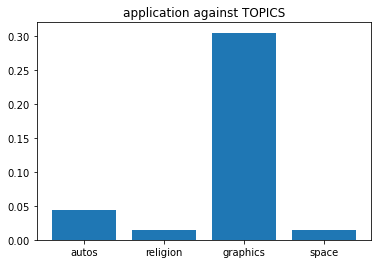

In [527]:
plt.title(f"{word} against TOPICS")
plt.bar(topic_word_distr.loc[word].index, topic_word_distr.loc[word])
plt.show()

### Evaluate Topic model with Train set

In [528]:
score = 0
print("Evaluating Topic Model...")
for doc_index in tqdm(range(len(train_labels))):
    doc_vector = train_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[train_labels[doc_index]])
    
    if score:
        continue
    
#     print(clean_docs[len(train_labels)+doc_index])
#     print("{:8s} {:16s} {:6s}".format("topic", "word", "relation"))
#     print("="*40)
#     for label, word in doc_topic_word_distr.idxmax().items():
#         print("{:8s} {:16s} {:.4f}".format(label, word, doc_topic_word_distr[label][word]))

#     print(f"\nthe topic predicted is ==> '{np.max(doc_topic_word_distr).idxmax()}'")
#     print(f"the actual topic is ==> '{label_classes[labels[doc_index]]}'")

train_accuracy = score / (doc_index + 1)
print(f"==> train-accuracy is {train_accuracy*100:.2f}%\n")

Evaluating Topic Model...



==> train-accuracy is 99.88%



### Evaluating Topic Model with test set

In [529]:
score = 0
print("Evaluating Topic Model...")

misclasified = []
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if doc_topic != label_classes[test_labels[doc_index]]:
        misclasified.append(doc_index)
    

test_accuracy = score / (doc_index + 1)
print(f"==> test-accuracy is {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%\n")

Evaluating Topic Model...



==> test-accuracy is 83.33%, avg-accuarcy = 91.60%



### Topic and word corelation

In [467]:
word_topic_cos = []
for topic, label in enumerate(label_classes):
    word_topic_frequency = word_doc_freqency[document_word_frequency['__labels__'] == topic].sum(0)
    trust_factor = trust_factor = sigmoid((word_doc_freqency > 0).sum(0))
    
    word_topic_co = (word_topic_frequency * trust_factor) / word_doc_total_frequency
    word_topic_co = word_topic_co[word_topic_co > 0.5].sort_values(ascending=False)
    
    word_topic_cos.append(word_topic_co)
    print(f"topic {topic} has {word_topic_co.shape} skew words")

topic 0 has (2846,) skew words
topic 1 has (4357,) skew words
topic 2 has (4098,) skew words
topic 3 has (5198,) skew words


In [470]:
topic_index = label_classes.index('autos')
word_topic_cos[topic_index][word_topic_cos[topic_index] > 0].sort_values(ascending=False)

dealer        1.000000
toyota        0.999999
honda         0.999983
torque        0.999877
autos         0.999877
                ...   
attachment    0.505226
treated       0.504564
birds         0.502817
forth         0.502713
ate           0.500768
Length: 2846, dtype: float64

### Building topic model

In [471]:
converged = False
last_accuracy = last_max_accuracy = 0
window_size = 1000
window_step = window_base_step = 100
decay_factor = 10

while not converged:
    print("Building Topic_word_distr_prime...")
    topic_word_distr_prime = build_topic_word_distr(label_classes, word_topic_cos, word_doc_freqency.columns, window_size, word_doc_total_frequency)

    score = 0
    print("Evaluating Topic Model...")
    for doc_index in tqdm(range(len(train_labels))):
        doc_vector = train_doc_vectors[doc_index]
        doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr_prime)
        score += int(doc_topic == label_classes[train_labels[doc_index]])

    accuracy = score / (doc_index + 1)
    print(f"==> topic_word_distr_prime has shape {topic_word_distr_prime.shape} from window_size {window_size} and window_step {window_step} accuracy is {accuracy*100:.2f}%\n")
    
    if abs(accuracy - last_max_accuracy) < 10e-8:
        print("accuracy low", abs(accuracy - last_max_accuracy))
        converged = True
        
    elif accuracy >= last_max_accuracy:
        window_size += window_step
        last_max_accuracy = accuracy
    
    else:
        if last_accuracy == last_max_accuracy:
            window_size -= window_step
            window_step = int(window_step / decay_factor)
            
            if not window_step:
                print("window decayed!!")
                converged = False
        window_size += window_step
        
    last_accuracy = accuracy
    
train_accuarcy = accuracy

Building Topic_word_distr_prime...



Evaluating Topic Model...



==> topic_word_distr_prime has shape (17523, 4) from window_size 1000 and window_step 100 accuracy is 88.81%

Building Topic_word_distr_prime...



Evaluating Topic Model...



==> topic_word_distr_prime has shape (17523, 4) from window_size 1100 and window_step 100 accuracy is 88.81%

accuracy low 0.0


In [472]:
topic_word_distr_prime.head()

,autos,religion,graphics,space
00,0.012234,0.007474,0.045914,0.012567
000,0.084010,0.012548,0.017954,0.012790
0000,0.012238,0.013600,0.020885,0.021937
00000,0.012238,0.013600,0.020885,0.021937
0001,0.015346,0.019153,0.015190,0.013731


In [473]:
label_classes

['autos', 'religion', 'graphics', 'space']

In [474]:
label_class = 'graphics'
# topic_word_distr_prime[label_class][topic_word_distr_prime[label_class] > 0].sort_values(ascending=False)
topic_word_distr_prime[label_class].sort_values(ascending=False)

lars         1.0
som          1.0
01a          1.0
mabe         1.0
ipas         1.0
            ... 
blimp        0.0
vell         0.0
maniac       0.0
shadowing    0.0
piker        0.0
Name: graphics, Length: 17523, dtype: float64

In [475]:
word="application"
topic_word_distr_prime.loc[word].sort_values(ascending=False)

graphics    0.080672
autos       0.018597
religion    0.015019
space       0.013106
Name: application, dtype: float64

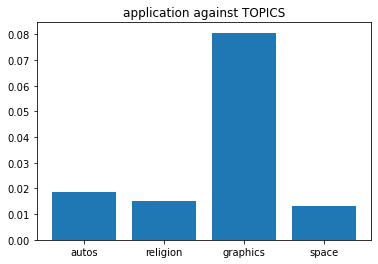

In [476]:
plt.title(f"{word} against TOPICS")
plt.bar(topic_word_distr_prime.loc[word].index, topic_word_distr_prime.loc[word])
plt.show()

### Testing Topic Model

In [477]:
score = 0
print("Evaluating Topic Model...")
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr_prime)
    score += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if score:
        continue
    
#     print(clean_docs[len(train_labels)+doc_index])
#     print("{:8s} {:16s} {:6s}".format("topic", "word", "relation"))
#     print("="*40)
#     for label, word in doc_topic_word_distr.idxmax().items():
#         print("{:8s} {:16s} {:.4f}".format(label, word, doc_topic_word_distr[label][word]))

#     print(f"\nthe topic predicted is ==> '{np.max(doc_topic_word_distr).idxmax()}'")
#     print(f"the actual topic is ==> '{label_classes[labels[doc_index]]}'")

test_accuracy = score / (doc_index + 1)
print(f"==> test-accuracy is {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%\n")

Evaluating Topic Model...



==> test-accuracy is 68.69%, avg-accuarcy = 84.22%



### Using Multinomial Naive Bayes

In [530]:
clf = MultinomialNB(alpha=.01)
clf.fit(train_doc_vectors, train_labels)

train_accuracy = clf.score(train_doc_vectors, train_labels)
test_accuracy = clf.score(test_doc_vectors, test_labels)

print(f"training_accuarcy = {train_accuracy*100:.2f}%, test_accuarcy = {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%")

training_accuarcy = 99.75%, test_accuarcy = 78.28%, avg-accuarcy = 89.02%


### Using Logistic Regression to Learn Topic Model

In [531]:
logistic_regression_model = LogisticRegression(
    random_state=0, 
    fit_intercept=False,
#     multi_class="multinomial", 
#     solver="lbfgs"
)

In [532]:
logistic_regression_model.fit(train_doc_vectors, train_labels)

print(f"{len(train_labels)} training sample(s), {len(test_labels)} test sample(s)")

804 training sample(s), 396 test sample(s)


In [533]:
train_accuracy = logistic_regression_model.score(train_doc_vectors, train_labels)
test_accuracy = logistic_regression_model.score(test_doc_vectors, test_labels)

print(f"training_accuarcy = {train_accuracy*100:.2f}%, test_accuarcy = {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%")

training_accuarcy = 68.91%, test_accuarcy = 51.77%, avg-accuarcy = 60.34%


In [482]:
label_class = 'graphics'
np.array(vocabulary)[logistic_regression_model.coef_[label_classes.index(label_class)].argsort()][::-1]

array(['graphics', 'file', 'thanks', ..., 'car', 'he', 'the'],
      dtype='<U79')

In [483]:
word="application"
relation = pd.DataFrame(data=logistic_regression_model.coef_[:, vocabulary.index(word)].reshape((1,len(label_classes))), columns=label_classes).T[0]
relation.sort_values(ascending=False)

graphics    0.075061
autos      -0.017920
space      -0.027392
religion   -0.029748
Name: 0, dtype: float64

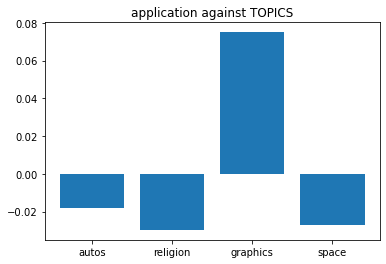

In [484]:
plt.title(f"{word} against TOPICS")
plt.bar(relation.index, relation)
plt.show()